In [1]:
import os
import zipfile
from pathlib import Path

def zip_folder(src_folder: Path, dst_zip: Path):
    with zipfile.ZipFile(dst_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(src_folder):
            for file in files:
                full_path = Path(root) / file
                relative_path = full_path.relative_to(src_folder)
                zipf.write(full_path, relative_path)

def process_dataset(root_dir: str, output_dir: str):
    root = Path(root_dir)
    output = Path(output_dir)
    output.mkdir(parents=True, exist_ok=True)

    for i in range(10):  # Process scene0000_00 to scene0009_00
        scene_name = f"scene{i:04d}_00"
        scene_dir = root / scene_name
        if scene_dir.exists() and scene_dir.is_dir():
            print(f"Processing {scene_name}")
            scene_output = output / scene_name
            scene_output.mkdir(parents=True, exist_ok=True)

            folder_mappings = {
                "gt": "gt.zip",
                "pseudo": "pseudo.zip",
                "rgb": "rgb.zip",
                "sam": "0.05_prompt_1296x968_sam.zip"
            }

            for folder_name, zip_name in folder_mappings.items():
                folder_path = scene_dir / folder_name
                if folder_path.exists() and folder_path.is_dir():
                    zip_path = scene_output / zip_name
                    zip_folder(folder_path, zip_path)
                else:
                    print(f"Warning: {folder_path} does not exist.")
        else:
            print(f"Scene folder {scene_name} not found.")

if __name__ == "__main__":
    process_dataset("processed_dataset/scans", "scans")

Processing scene0000_00
Processing scene0001_00
Processing scene0002_00
Processing scene0003_00
Processing scene0004_00
Processing scene0005_00
Processing scene0006_00
Processing scene0007_00
Processing scene0008_00
Processing scene0009_00


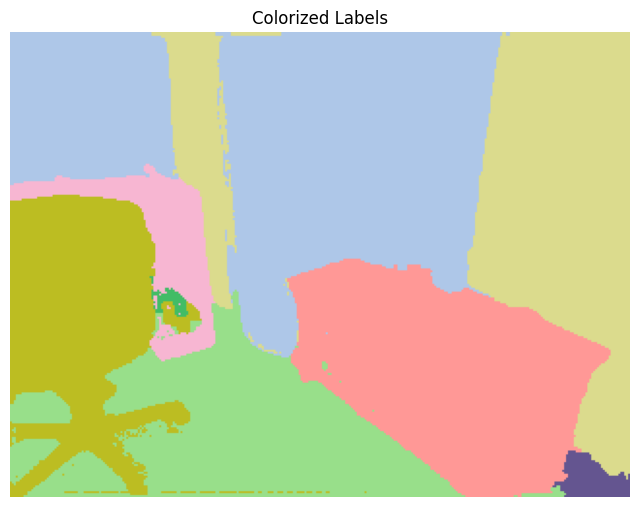

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
def labels_to_rgb(label_img,class_colors):
    """Convert label indices (H, W) to RGB image using predefined colormap."""
    sem_new = np.zeros((label_img.shape[0], label_img.shape[1], 3), dtype=np.uint8)
    for i in range(41):  # self.max_classes is 41
        sem_new[label_img == i] = class_colors[i]
    return sem_new
mapping = np.genfromtxt("nyu40_segmentation_mapping.csv", delimiter=",")[1:, 1:4]
class_colors = mapping
image_bgr = cv2.imread("processed_dataset/scene0000_00/samAb5/1.png", cv2.IMREAD_GRAYSCALE)
res=labels_to_rgb(image_bgr,class_colors)

# Show the colorized label image
plt.figure(figsize=(8, 8))
plt.imshow(res)
plt.axis("off")
plt.title("Colorized Labels")
plt.show()

In [ ]:
import os
from pathlib import Path
import numpy as np
import cv2
from metrics import SemanticsMeter  # Ensure this is saved in the same directory


def load_and_adjust(path):
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)  # Keep exact pixel values
    if img is None:
        raise ValueError(f"Could not read image: {path}")
    if img.ndim == 3:
        # If the image has 3 channels but it's actually a label map,
        # reduce it to a single channel.
        img = img[:, :, 0]
    return img.astype(np.int32) - 1  # shift: original 0–39 -> -1 to 38


def natural_sort_key(p):
    return int(p.stem) if p.stem.isdigit() else p.stem


def compute_metrics_on_range(
    root_path: str,
    start_scene: int,
    end_scene: int,
    num_classes: int,
    percentage: float = 1.0
):
    root = Path(root_path)
    global_meter = SemanticsMeter(num_classes)
    scene_results = []

    for i in range(start_scene, end_scene + 1):
        scene_name = f"scene{i:04d}_00"
        scene_path = root / scene_name
        gt_dir = scene_path / "gt"
        sam_dir = scene_path / "samCb5"

        if not gt_dir.exists() or not sam_dir.exists():
            print(gt_dir,sam_dir)
            print(f"Skipping {scene_name}: missing gt or sam directory.")
            continue

        gt_files = sorted(gt_dir.glob("*.png"), key=natural_sort_key)
        sam_files = sorted(sam_dir.glob("*.png"), key=natural_sort_key)

        min_len = min(len(gt_files), len(sam_files))
        if min_len == 0:
            print(f"Skipping {scene_name}: no images.")
            continue

        num_to_process = max(1, int(min_len * percentage))
        gt_files = gt_files[:num_to_process]
        sam_files = sam_files[:num_to_process]

        scene_meter = SemanticsMeter(num_classes)

        for gt_file, sam_file in zip(gt_files, sam_files):
            gt_img = load_and_adjust(gt_file)
            sam_img = load_and_adjust(sam_file)

            if gt_img.shape != sam_img.shape:
                print(f"Shape mismatch in {gt_file.name}, skipping.")
                continue

            if np.all(gt_img == -1) or np.all(sam_img == -1):
                print(f"Skipping {gt_file.name}: prediction or ground truth is fully void.")
                continue

            scene_meter.update(sam_img, gt_img)
            global_meter.update(sam_img, gt_img)

        try:
            miou, acc, class_acc = scene_meter.measure()
            scene_results.append((scene_name, miou, acc, class_acc))
            print(f"Scene {scene_name} — mIoU: {miou:.4f} | Acc: {acc:.4f} | ClassAcc: {class_acc:.4f}")
        except Exception:
            print(f"Scene {scene_name} — No valid data for metrics.")

    # === Summary Table ===
    print("\n===== PER-SCENE METRICS =====")
    print(f"{'Scene':<20} {'mIoU':>8} {'Accuracy':>10} {'ClassAcc':>10}")
    print("-" * 50)
    for scene_name, miou, acc, class_acc in scene_results:
        print(f"{scene_name:<20} {miou:>8.4f} {acc:>10.4f} {class_acc:>10.4f}")

    print("\n===== GLOBAL METRICS =====")
    miou, total_acc, class_avg_acc = global_meter.measure()
    print(f"Mean IoU:           {miou:.4f}")
    print(f"Total Accuracy:     {total_acc:.4f}")
    print(f"Class Avg Accuracy: {class_avg_acc:.4f}")


if __name__ == "__main__":
    compute_metrics_on_range(
        root_path="processed_dataset",
        start_scene=0,
        end_scene=1,
        num_classes=40,
        percentage=0.8  # Use 80% of frames per scene
    )


Exception ignored in: <function PluginV3.__del__ at 0x7f707c63c550>
Traceback (most recent call last):
  File "/home/adaptation/miniconda3/envs/DAP/lib/python3.8/site-packages/imageio/core/v3_plugin_api.py", line 370, in __del__
    self.close()
  File "/home/adaptation/miniconda3/envs/DAP/lib/python3.8/site-packages/imageio/plugins/pillow.py", line 144, in close
    self._flush_writer()
  File "/home/adaptation/miniconda3/envs/DAP/lib/python3.8/site-packages/imageio/plugins/pillow.py", line 476, in _flush_writer
    if len(self.images_to_write) == 0:
AttributeError: 'PillowPlugin' object has no attribute 'images_to_write'


KeyboardInterrupt: 